In [ ]:
import numpy as np
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
TISSUE = 'kidney'
VERSION = 'final'

Plot intro figure showing batch effects on PODXL. Use hi-res JPEGs.

In [4]:
df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)
urls = df.query('`Gene name`=="PODXL"').groupby('Batch').sample(n=1,random_state=0)['URL'][:4].tolist()
urls

['http://images.proteinatlas.org/2110/141299_A_7_5.jpg',
 'http://images.proteinatlas.org/16169/36664_A_9_5.jpg',
 'http://images.proteinatlas.org/45507/113968_A_7_5.jpg',
 'http://images.proteinatlas.org/62558/140923_A_9_5.jpg']

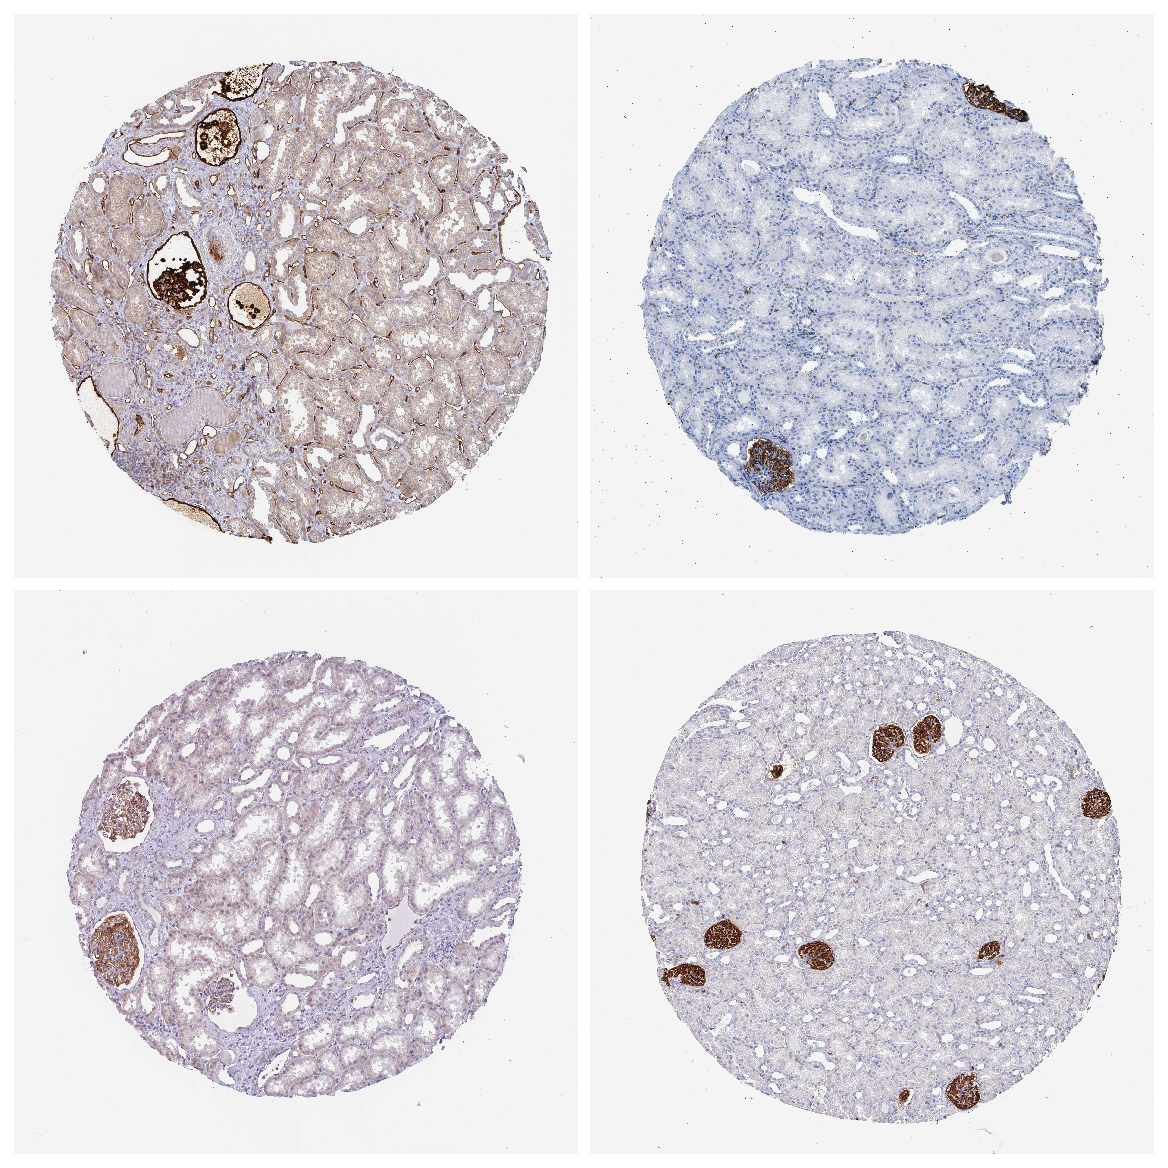

In [57]:
from imageio import imread
figsize=4
fig,axs=plt.subplots(2,2,figsize=(2*figsize,2*figsize),constrained_layout=True)
axs=axs.ravel()
for i, url in enumerate(urls):
    path = './figures/'+url.split('/')[-1]
    img = imread(path)
    axs[i].matshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].axis('off')
    axs[i].axis('off')
plt.savefig('./figures/podxl.png', dpi=300)

Outline Leiden clusters for UMAP figure.

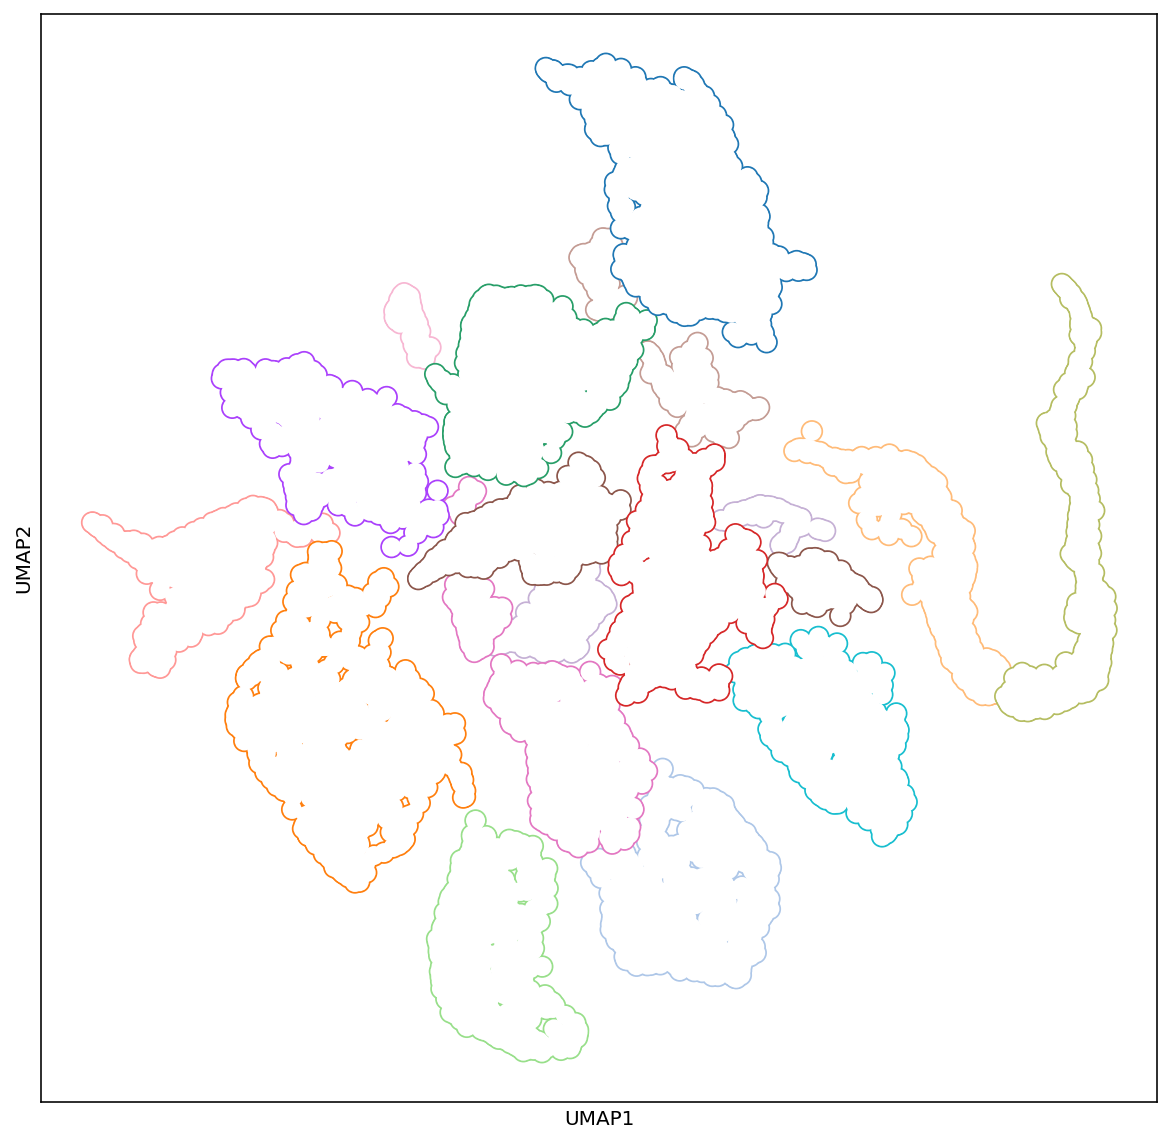

In [23]:
adata = sc.read('./scratch/kidney_final.h5')

fig, ax = plt.subplots(figsize=(10,10))
from sklearn.neighbors import kneighbors_graph
G = kneighbors_graph(adata.obsm['X_umap'],10)
is_artifact = np.zeros(len(adata),dtype=bool)
for i in range(len(is_artifact)):
    _, idx = G[i].nonzero()
    is_artifact[i] = sum(adata.obs['leiden'][idx] == adata.obs['leiden'][i]) < 8
for i,l in list(enumerate(adata.obs['leiden'].cat.categories))[::-1]:
    sc.pl.umap(adata, na_color='white', ax=ax, na_in_legend=False, show=False,
               add_outline=True, outline_color=(adata.uns['leiden_colors'][i],'white'),
               s=300*(adata.obs['leiden']==l)*(~is_artifact),
              outline_width=(0.1, 0.05))
plt.savefig('./figures/umap_outlines.png', dpi=300)

Select cluster exemplars via SVM.

In [ ]:
from imageio import imread
from sklearn.svm import SVC
 
df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)

# Some images are associated with multiple genes (i.e. nonspecific antibody); we remove these.
df['duplicated'] = df.index.value_counts()[df.index] > 1

# Only include high-quality images.
df = ( df.query('(Staining=="high")|(Staining=="medium")')
         .query('Reliability=="Enhanced"')
         .query('~duplicated') )

y = adata.obs['leiden'].astype(int)
svm = SVC(kernel='rbf',C=1.0,probability=True,random_state=0)
svm.fit(adata.X, y)
cluster_scores = pd.DataFrame(lm.predict_proba(adata.X),index=adata.obs_names)

image_names = dict(zip(df.index,df['Gene name']))
gene_names = dict(zip(df.index,df['Gene']))
cell_types = sorted(adata.obs['leiden'].astype(int).unique())

figsize=2

figs = plt.figure(constrained_layout=True,figsize=(nfigs*figsize,len(cell_types)*figsize)).subfigures(len(cell_types), 1)

for j,c in enumerate(cell_types):
    names = cluster_scores[c].sort_values(ascending=False).index.tolist()
    nfigs = 5
    names = names[:nfigs]
    axs = figs[j].subplots(1,nfigs)
    figs[j].suptitle(f'cluster {c}',x=0.03,ha='left')
    for i, name in enumerate(names):
        batch = df.loc[name]['Batch']
        path = f'./data/images/kidney/{batch}/{name}.png'
        img = imread(path)
        axs[i].matshow(img)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(image_names[name])# + ' %.2f'%rna[c][gene_names[name]])
        axs[i].axis('off')
# plt.savefig('./figures/exemplars.png', dpi=300)